# Real-world case study

---

In this lab, you'll work with in pairs or small groups to classify movie genres in the [Sakila](https://dev.mysql.com/doc/sakila/en/sakila-structure.html) database. You'll apply the skills you've learned in MySQL and exploratory data analysis to acquire, explore, clean, and process the data. After some feature selection (and/or feature engineering) you'll train a model to predict the genre of a movie given other information about it.

---

**Useful links:**
* Overview of the [structure](https://dev.mysql.com/doc/sakila/en/sakila-structure.html) of the database
* List of [tables](https://dev.mysql.com/doc/sakila/en/sakila-structure-tables.html) and summaries of their content

---

Start by importing relevant libraries:

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import cmocean
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


viz_style = {
    'font.family': 'sans-serif',
    'font.size':11,
    'axes.titlesize':'large',
    'axes.labelsize':'medium',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'text.color':'#5B5654',
    'axes.labelcolor':'#5B5654',
    'xtick.color':'#5B5654',
    'ytick.color':'#5B5654',
    'axes.edgecolor':'#5B5654',
    'xtick.top':False,
    'ytick.right':False,
    'axes.spines.top':False,
    'axes.spines.right':False,
    'axes.grid':False,
    'boxplot.showfliers':False,
    'boxplot.patchartist':True
}

plt.style.use(viz_style)

case_dir = '/path/to/materials'

## Read in & explore the data

Use mysql to query the database. 

---

This lab is open-ended, so you can explore the database and decide which features might be useful to have when predicting movie genre. Remember that you can do on-the-fly feature engineering in your SQL queries!

In [2]:
import pymysql
import sqlalchemy as db

# note: this part might be different in a class setting?
db_url = os.path.join(case_dir, 'sakila.db')
engine = db.create_engine('sqlite:///'+db_url)
metadata = db.MetaData()
connection = engine.connect()

In [3]:
query = '''
select f.*, 
    fc.category_id, c.name as genre,
    count(distinct(a.actor_id)) as num_actors,
    count(distinct(i.inventory_id)) as num_copies,
    count(distinct(r.rental_id)) as num_rentals

from film f 
    left join film_actor a on f.film_id = a.film_id
    left join film_category fc on f.film_id = fc.film_id
    left join category c on fc.category_id = c.category_id
    left join inventory i on f.film_id = i.film_id
    left join rental r on i.inventory_id = r.inventory_id

group by f.film_id;

'''
df = pd.read_sql(query, con=engine)

# some feature engineering
df['rentals_per_copy'] = df['num_rentals'].div(df['num_copies'])

# one-hot encoding for special features (by hand, could also do via sklearn)
df['deleted_scenes'] = df['special_features'].str.contains('Deleted Scenes').astype(int)
df['bts'] = df['special_features'].str.contains('Behind the Scenes').astype(int)
df['trailers'] = df['special_features'].str.contains('Trailers').astype(int)
df['commentary'] = df['special_features'].str.contains('Commentaries').astype(int)

# ordinal encoding for rating and genre (by hand, could also do via sklearn)
df['rating_int'] = df['rating'].map({'G':0, 'PG':1, 'PG-13':2, 'NC-17':3, 'R':4})
df['genre_int'] = df['genre'].map({ genre:i for i,genre in enumerate(df['genre'].unique()) })
df

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,...,num_actors,num_copies,num_rentals,rentals_per_copy,deleted_scenes,bts,trailers,commentary,rating_int,genre_int
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,...,10,8,23,2.875000,1,1,0,0,1,0
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,...,4,3,7,2.333333,1,0,1,0,0,1
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,...,5,4,12,3.000000,1,0,1,0,3,0
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,...,5,7,23,3.285714,0,1,0,1,0,1
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,...,5,3,12,4.000000,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,A Unbelieveable Yarn of a Boat And a Database ...,2006,1,None,6,0.99,183,9.99,...,5,2,7,3.500000,0,1,1,0,0,0
996,997,YOUTH KICK,A Touching Drama of a Teacher And a Cat who mu...,2006,1,None,4,0.99,179,14.99,...,5,2,6,3.000000,0,1,1,0,3,6
997,998,ZHIVAGO CORE,A Fateful Yarn of a Composer And a Man who mus...,2006,1,None,6,0.99,105,10.99,...,6,2,9,4.500000,1,0,0,0,3,1
998,999,ZOOLANDER FICTION,A Fateful Reflection of a Waitress And a Boat ...,2006,1,None,5,2.99,101,28.99,...,5,5,17,3.400000,1,0,1,0,4,15


We'll be dealing with some light class imbalance here (and a lot of classes!)

In [4]:
df['genre'].value_counts()

Sports         74
Foreign        73
Family         69
Documentary    68
Animation      66
Action         64
New            63
Drama          62
Sci-Fi         61
Games          61
Children       60
Comedy         58
Travel         57
Classics       57
Horror         56
Music          51
Name: genre, dtype: int64

Let's see what relationships these features have with the genre:

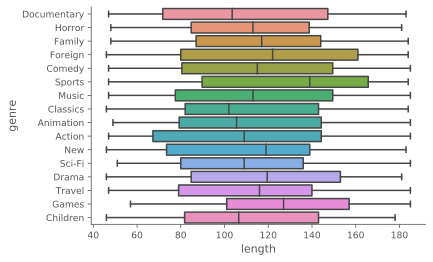

In [5]:
sns.boxplot(y='genre', x='length',data=df);

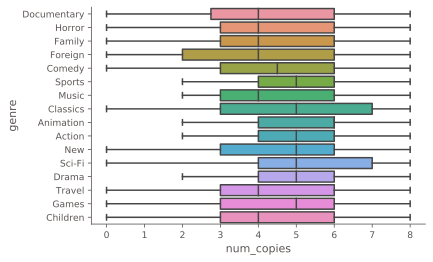

In [6]:
sns.boxplot(y='genre', x='num_copies',data=df);

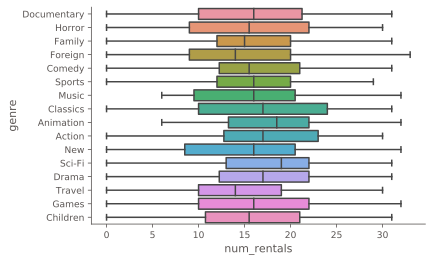

In [7]:
sns.boxplot(y='genre', x='num_rentals',data=df);

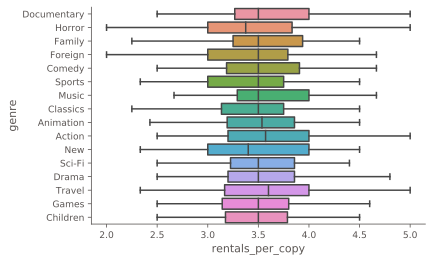

In [8]:
sns.boxplot(y='genre', x='rentals_per_copy',data=df);

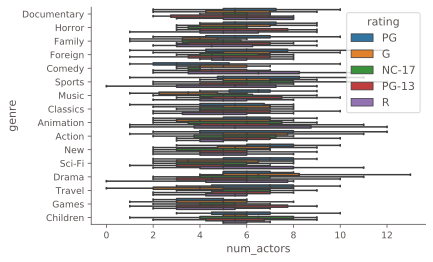

In [9]:
sns.boxplot(y='genre', x='num_actors',hue='rating',data=df)

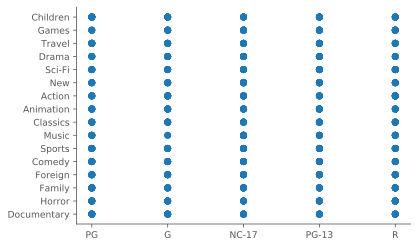

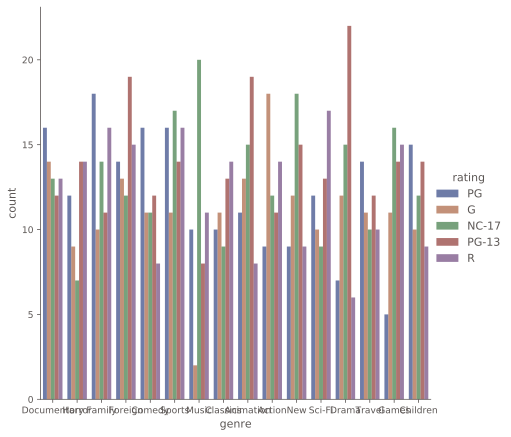

In [10]:
plt.plot(df['rating'], df['genre'],'o')

sns.catplot(
    data=df, kind="count",
    x="genre", hue="rating",
    ci="sd", palette="dark", alpha=.6, height=6);

^ the above is surprising. 

... this is a fictional database, so maybe we shouldn't expect reasonable results here? e.g. movies in the 'Children' genre should be, well, for children, but 12 of the 60 are rated NC-17 and 9 are rated R!

In [11]:
df.loc[df['genre']=='Children', 'rating'].value_counts()

PG       15
PG-13    14
NC-17    12
G        10
R         9
Name: rating, dtype: int64

There are also several features that contain no information, e.g.

In [12]:
df['language_id'].unique(), df['original_language_id'].unique(), df['release_year'].unique()

(array([1]), array([None], dtype=object), array(['2006'], dtype=object))

## train model

### Individual genres (all)

We'll start by trying to predict each individual genre.

Note to instructors: as mentioned above, since this is a fictional database, we likely do not have enough information to train a reliable classifier. The following sets up the problem anyway (for completeness).

---

Specify target & features:

In [13]:
target = 'genre_int'
feature_names = ['rental_duration', 'rental_rate', 'length', 'replacement_cost', 'rating_int', 
                 'num_actors', 'rentals_per_copy', 'deleted_scenes', 'bts', 'trailers', 'commentary']

df[feature_names]

,rental_duration,rental_rate,length,replacement_cost,rating_int,num_actors,rentals_per_copy,deleted_scenes,bts,trailers,commentary
0,6,0.99,86,20.99,1,10,2.875000,1,1,0,0
1,3,4.99,48,12.99,0,4,2.333333,1,0,1,0
2,7,2.99,50,18.99,3,5,3.000000,1,0,1,0
3,5,2.99,117,26.99,0,5,3.285714,0,1,0,1
4,6,2.99,130,22.99,0,5,4.000000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
995,6,0.99,183,9.99,0,5,3.500000,0,1,1,0
996,4,0.99,179,14.99,3,5,3.000000,0,1,1,0
997,6,0.99,105,10.99,3,6,4.500000,1,0,0,0
998,5,2.99,101,28.99,4,5,3.400000,1,0,1,0


Check for any missing values:

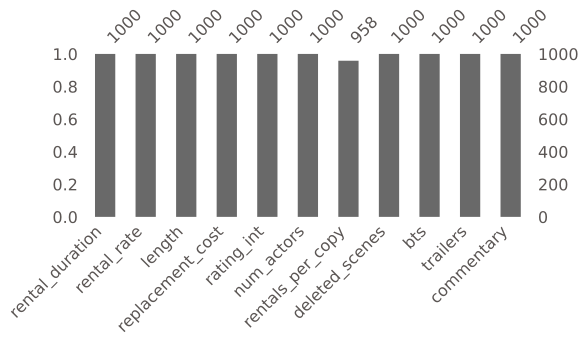

In [14]:
import missingno as msno
msno.bar(df[feature_names], figsize=(8,3))

We'll drop rows where there are zero copies in inventory:

In [15]:
df_clean = df[df['num_copies'] > 0]

And now we'll do our train/test split:

In [16]:
from sklearn.model_selection import train_test_split

X = df_clean[feature_names]
y = df_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25, stratify=y)

We'll go immediately into a grid search to optimize:

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

parameters = {'C':10**np.linspace(-2,2, 11)}
gs = GridSearchCV(LogisticRegression(multi_class='multinomial', random_state=0), 
                  parameters, scoring='recall_macro').fit(X_train_sc, y_train)
print('Best params:', gs.best_params_)

Best params: {'C': 1.0}


In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def summarize_scores(y_true, y_pred, settype='Training'):
    print('\n--- {} SET ---'.format(settype.upper()))
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, average='macro'))
    print('Recall:', recall_score(y_true, y_pred, average='macro'))
    print('F1:', f1_score(y_true, y_pred, average='macro'))
    
summarize_scores(y_train, gs.predict(X_train_sc), settype='Training')
summarize_scores(y_test, gs.predict(X_test_sc), settype='Test')


--- TRAINING SET ---
Accuracy: 0.11977715877437325
Precision: 0.11786170206660056
Recall: 0.11696220921131048
F1: 0.11051446343526261

--- TEST SET ---
Accuracy: 0.10416666666666667
Precision: 0.09834905344016598
Recall: 0.09765299549306902
F1: 0.0902321883966137


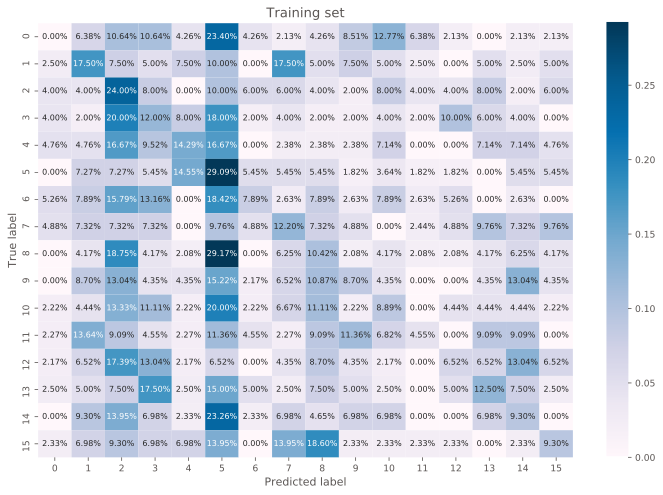

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))
heatmap_train = sns.heatmap(confusion_matrix(y_train, gs.predict(X_train_sc), normalize="true"), 
                            annot=True, annot_kws={"fontsize":8}, fmt='.2%', cmap="PuBu", ax=axes);
axes.set_xlabel('Predicted label')
axes.set_ylabel('True label')
axes.set_title('Training set');

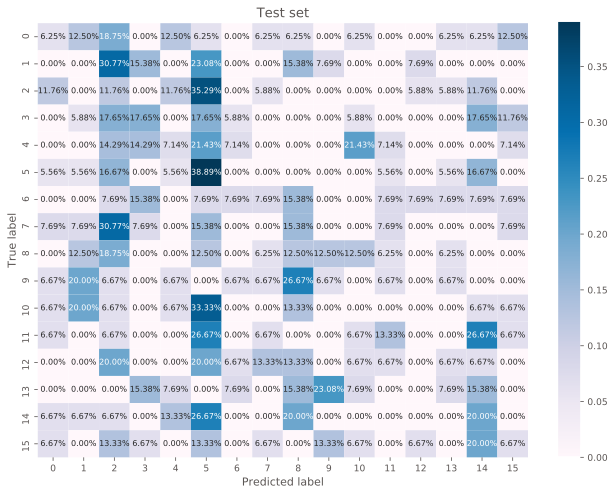

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(11,8))
heatmap_test = sns.heatmap(confusion_matrix(y_test, gs.predict(X_test_sc), normalize="true"), 
                           annot=True, annot_kws={"fontsize":8}, fmt='.2%', cmap="PuBu", ax=axes);
axes.set_xlabel('Predicted label')
axes.set_ylabel('True label')
axes.set_title('Test set');

yikes

### Combined genres

Some of the genres could concievably be combined:

In [22]:
df['genre'].unique()

array(['Documentary', 'Horror', 'Family', 'Foreign', 'Comedy', 'Sports',
       'Music', 'Classics', 'Animation', 'Action', 'New', 'Sci-Fi',
       'Drama', 'Travel', 'Games', 'Children'], dtype=object)

We'll add two "combo" genres:

In [23]:
kid_friendly = ['Family', 'Music', 'Animation', 'Children']
educational = ['Documentary', 'Travel']

df['genre_combo'] = ['kid_friendly' if genre in kid_friendly 
                     else 'educational' if genre in educational 
                     else genre for genre in df['genre']]

df['genre_combo_int'] = df['genre_combo'].map({ genre:i for i,genre in enumerate(df['genre_combo'].unique()) })
df['genre_combo']

0       educational
1            Horror
2       educational
3            Horror
4      kid_friendly
           ...     
995     educational
996    kid_friendly
997          Horror
998    kid_friendly
999          Comedy
Name: genre_combo, Length: 1000, dtype: object

Now we can redefine the train/test sets with this new target variable:

In [24]:
drop_genres = ['New', 'Games', 'Music']

df_clean = df[(df['num_copies'] > 0) & (df['genre'] != 'New') & 
              (df['genre'] != 'Games') & (df['genre'] != 'Music')]

target = 'genre_combo_int'
X = df_clean[feature_names]
y = df_clean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25, stratify=y)
y_train.value_counts()#.sum()

2     141
0      87
5      55
3      50
10     46
7      46
9      44
4      42
6      40
1      40
Name: genre_combo_int, dtype: int64

In [25]:
# scale features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# train model w grid search optimization
parameters = {'C':10**np.linspace(-2,2, 11)}
gs = GridSearchCV(LogisticRegression(multi_class='multinomial', random_state=0), 
                  parameters, scoring='recall_macro').fit(X_train_sc, y_train)
print('Best params:', gs.best_params_)

# evaluate model results
summarize_scores(y_train, gs.predict(X_train_sc), settype='Training')
summarize_scores(y_test, gs.predict(X_test_sc), settype='Test')

Best params: {'C': 1.0}

--- TRAINING SET ---
Accuracy: 0.2639593908629442
Precision: 0.11255074013035797
Recall: 0.13937272949598703
F1: 0.1026513029454206

--- TEST SET ---
Accuracy: 0.20202020202020202
Precision: 0.10996449456975772
Recall: 0.10696951769213432
F1: 0.07816080794430567


/anaconda2/envs/dfdev/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda2/envs/dfdev/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


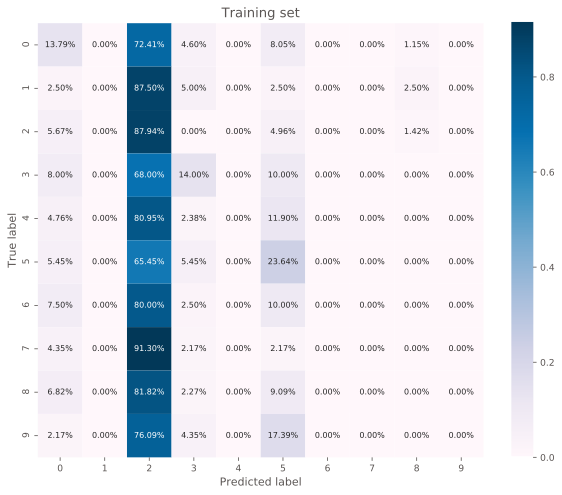

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(10,8))
heatmap_train = sns.heatmap(confusion_matrix(y_train, gs.predict(X_train_sc), normalize="true"), 
                            annot=True, annot_kws={"fontsize":8}, fmt='.2%', cmap="PuBu", ax=axes);
axes.set_xlabel('Predicted label')
axes.set_ylabel('True label')
axes.set_title('Training set');

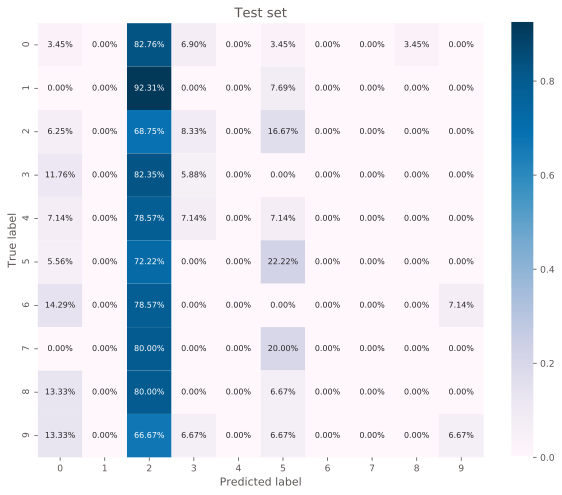

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(10,8))
heatmap_test = sns.heatmap(confusion_matrix(y_test, gs.predict(X_test_sc), normalize="true"), 
                           annot=True, annot_kws={"fontsize":8}, fmt='.2%', cmap="PuBu", ax=axes);
axes.set_xlabel('Predicted label')
axes.set_ylabel('True label')
axes.set_title('Test set');

well this is worse - now almost everything is predicted to be class 2 =/